In [ ]:
pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#from mpl_toolkits import mplot3d
from matplotlib import pyplot
import math
from PIL import Image, ImageFilter
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import shutil


In [ ]:
# defining the canny detector function

# here weak_th and strong_th are thresholds for
# double thresholding step
def Canny_detector(img, weak_th = None, strong_th = None):
	
	# conversion of image to grayscale
	img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	
	# Noise reduction step
	img = cv2.GaussianBlur(img, (5, 5), 1.8) #(5,5)
	cv2.imwrite("blur.png",img)
	# Calculating the gradients
	gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
	gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
	
	# Conversion of Cartesian coordinates to polar
	mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
	
	# setting the minimum and maximum thresholds
	# for double thresholding
	mag_max = np.max(mag)
	if not weak_th:weak_th = mag_max * 0.225 #0.225 to 0.2
	if not strong_th:strong_th = mag_max * 0.215 #0.215 to 1
	
	# getting the dimensions of the input image
	height, width = img.shape
	
	# Looping through every pixel of the grayscale
	# image
	for i_x in range(width):
		for i_y in range(height):
			
			grad_ang = ang[i_y, i_x]
			grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
			
			# selecting the neighbours of the target pixel
			# according to the gradient direction
			# In the x axis direction
			if grad_ang<= 22.5:
				neighb_1_x, neighb_1_y = i_x-1, i_y
				neighb_2_x, neighb_2_y = i_x + 1, i_y
			
			# top right (diagonal-1) direction
			elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
				neighb_1_x, neighb_1_y = i_x-1, i_y-1
				neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
			
			# In y-axis direction
			elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
				neighb_1_x, neighb_1_y = i_x, i_y-1
				neighb_2_x, neighb_2_y = i_x, i_y + 1
			
			# top left (diagonal-2) direction
			elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
				neighb_1_x, neighb_1_y = i_x-1, i_y + 1
				neighb_2_x, neighb_2_y = i_x + 1, i_y-1
			
			# Now it restarts the cycle
			elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
				neighb_1_x, neighb_1_y = i_x-1, i_y
				neighb_2_x, neighb_2_y = i_x + 1, i_y
			
			# Non-maximum suppression step
			if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
				if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
					mag[i_y, i_x]= 0
					continue

			if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
				if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
					mag[i_y, i_x]= 0

	weak_ids = np.zeros_like(img)
	strong_ids = np.zeros_like(img)			
	ids = np.zeros_like(img)
	
	# double thresholding step
	for i_x in range(width):
		for i_y in range(height):
			
			grad_mag = mag[i_y, i_x]
			
			if grad_mag<weak_th:
				mag[i_y, i_x]= 0
			elif strong_th>grad_mag>= weak_th:
				ids[i_y, i_x]= 1
			else:
				ids[i_y, i_x]= 2
	
	
	# finally returning the magnitude of
	# gradients of edges
	return mag



Inspiration for Edge Detection Code: https://www.geeksforgeeks.org/implement-canny-edge-detector-in-python-using-opencv/?ref=lbp

True

<Figure size 640x480 with 0 Axes>

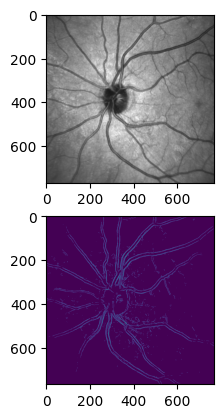

In [ ]:
df = pd.DataFrame()

folder_path = "AIR_unlabeled_data"


frame = cv2.imread(folder_path + "/29_uw_IR.png")

# calling the designed function for
# finding edges
canny_img = Canny_detector(frame)



# Displaying the input and output image
plt.figure()
f, plots = plt.subplots(2, 1)
plots[0].imshow(frame)
plots[1].imshow(canny_img)
cv2.imwrite("edges.png",canny_img)

124.1933975700802

In [ ]:
np_img = numpy.array(canny_img)
for i in range(len(np_img)):
  for p in range(len(np_img)):
    if np_img[i][p]<50:
      np_img[i][p] = 255
    else:
      np_img[i][p] = 0
cv2.imwrite("solid_edges.png",np_img)

True

In [ ]:
preimg = np.copy(np_img)

In [ ]:
import statistics

def checkAround(img, yval, xval, dist):
    total = []
    #amtPix = 0
    for i in range(2 * dist + 1):
        for j in range(2 * dist + 1):
            curY = yval + i - dist
            curX = xval + j - dist
            if(curY >= 0 and curY < 768 and curX >= 0 and curX < 768):
                total.append(frame[curY][curX])
                #amtPix += 1

    return statistics.median(total)


In [ ]:
dist=18

def checkUp(img, yval,xval,distr):
  #for u in range(distr):
    #if (yval - u) < 0:
      #return False
    #if preimg[yval - u][xval] == 0:
      #return True
  #return False
  ind = 1
  while((yval - ind) >= 0 and ind < dist):
    if img[yval - ind][xval] == 0:
      return ind
    ind+=1
  return ind + 15

def checkDown(img, yval,xval,distr):
  #for u in range(distr):
    #if (yval + u) > 767:
      #return False

    #print(newimg[yval + u][xval])
    #if preimg[yval + u][xval] == 0:
      #return True
  #return False
  ind = 1
  while((yval + ind) < 768 and ind < dist):
    if img[yval + ind][xval] == 0:
      return ind
    ind+=1
  return ind + 15

def checkLeft(img,yval,xval,distr):
  #for u in range(distr):
    #if (xval - u) < 0:
      #return False
    #if preimg[yval][xval - u] == 0:
      #return True
  #return False
  ind = 1
  while((xval - ind) >= 0 and ind < dist):
    if img[yval][xval - ind] == 0:
      return ind
    ind+=1
  return ind + 15

def checkRight(img, yval,xval,distr):
  #for u in range(distr):
    #if (xval + u) > 767:
      #return False

    #if preimg[yval][xval + u] == 0:
      #return True
  #return False
  ind = 1
  while((xval + ind) < 768 and ind < dist):
    if img[yval][xval + ind] == 0:
      return ind
    ind+=1
  return ind + 15



In [ ]:
def averages(frame, size):
  
#first index is y and second is x, so [1, 10] is top right
  M, N = frame.shape
  K = size
  L = size

  MK = M // K
  NL = N // L
  return(frame[:MK*K, :NL*L].reshape(MK, K, NL, L).mean(axis=(1, 3)))

In [ ]:
#postimg = np.copy(preimg)


def segGuess(frame, edges):

  postimg = np.zeros((768, 768))
  postimg = np.where(postimg == 0, 255, 0)
  bigRegionSize = 64
  smallRegionSize = 16
  bigRegions = averages(frame, bigRegionSize)
  smallRegions = averages(frame, smallRegionSize)
  test0 = []
  test1 = []
  for i in range(len(frame)):
    for p in range(len(frame)):
      
      color = frame[i][p]
      color_norm = color / 255
      height = checkUp(edges,i,p,dist) + checkDown(edges,i,p,dist)
      width = checkLeft(edges,i,p,dist) + checkRight(edges,i,p,dist)
      if(height > 20):
        height = 1000
      if(width > 20):
        width = 1000

      width_norm = 0
      height_norm = 0

      if(0 < width < 13):
        width_norm = 1
      elif(width < 17):
        width_norm = 0.75
      if(0 < height < 13):
        height_norm = 1
      elif(height < 17):
        height_norm = 0.75

      #height_norm = 1 / ((abs(height - 10)) / 10 + 1)
      #width_norm = 1 / ((abs(width - 10)) / 10 + 1)

      bigxColumn = int(p / bigRegionSize)
      bigyColumn = int(i / bigRegionSize)
      bigRegionColor = bigRegions[bigyColumn][bigxColumn]
      bigColorDif = bigRegionColor - color
      bigColorDif_norm = bigColorDif / 40

      smallxColumn = int(p / smallRegionSize)
      smallyColumn = int(i / smallRegionSize)
      smallRegionColor = smallRegions[smallyColumn][smallxColumn]
      smallColorDif = smallRegionColor - color
      smallColorDif_norm = smallColorDif / 40

      around = checkAround(frame, i, p, 3)
      aroundDif = bigRegionColor - around
      aroundDif_norm = aroundDif / 40
      test0.append(aroundDif_norm)
      test1.append(bigColorDif_norm)
      if(aroundDif > 10 and bigColorDif > 0 and color < 160):
        #postimg[i][p] = 0
        if(max(height_norm, width_norm) == 1):
          #continue
          #basically gauranteed!
          postimg[i][p] = 0
          # and aroundDif > 15
        if(bigColorDif > 25):
          #continue
          #litle bit of noise
          postimg[i][p] = 0
        if(smallColorDif > 10):
          #highly distributed + noise
          postimg[i][p] = 0
          #continue

  

      """
      if(color < 150):

        if(max(height_norm, width_norm) > 0.2):
            #test0.append(bigColorDif_norm)
            if(max(height_norm, width_norm) + bigColorDif_norm > 1):
              postimg[i][p] = 0
              
        else:
          #test1.append(bigColorDif_norm)
          if(bigColorDif_norm > 0.5 and smallColorDif_norm > 0.2):
            postimg[i][p] = 0

      """
      #if(0.3 * max(height_norm, width_norm) + 0.7 * colorDif_norm > 0.5):
        #postimg[i][p] = 0
          
      
      

      #if (frame[i][p][0] < 150):
        #if ((checkUp(i,p,dist)) and (checkDown(i,p,dist))):
          #postimg[i][p] = 0;
        #elif ((checkLeft(i,p,dist)) and (checkRight(i,p,dist)) ):
          #postimg[i][p] = 0;
  return postimg

In [ ]:
folder_path = "AIR_unlabeled_data"

# Create an empty list to store the images and their file names
preImages = []
postImages = []
file_names = []
#f = open("test.txt")
#print(os.listdir)

#print(os.listdir("images"))

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    
    # Check if the file is an image (e.g. JPEG, PNG)
    if filename.endswith('.png'):
        
        # Load the image using the PIL library
        frame = cv2.imread(folder_path + "/" + filename)
        canny_img = Canny_detector(frame)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        print(frame.shape)
        

        
        np_img = numpy.array(canny_img)
        
        for i in range(len(np_img)):
            for p in range(len(np_img)):
                if np_img[i][p]<50:
                    np_img[i][p] = 255
                else:
                    np_img[i][p] = 0
        
        #print(frame)
        #print(np_img)

        postimg = segGuess(frame, np_img)

        print(postimg)

        newimg_swap = np.where(postimg > 0, 0, 255)

        
        cv2.imwrite(filename[:-4] + "_post.png",newimg_swap)
        shutil.move(filename[:-4] + "_post.png", "postImages")
        # Add the image and file name to the lists
        preImages.append(frame)
        postImages.append(newimg_swap)
        file_names.append(filename)

# Create a DataFrame with the images and file names
df = pd.DataFrame({'pre_image': preImages, 'post_image': postImages, 'file_name': file_names})



In [ ]:
preImages = df.pre_image
preImages = preImages.to_frame()

print(type(preImages.iloc[0]))




<class 'pandas.core.series.Series'>


In [ ]:
plt.hist(test0, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');



In [ ]:
plt.hist(test1, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

In [ ]:
cv2.imwrite("black_seg.png",postimg)
newimg_swap = np.where(postimg > 0, 0, 255)
cv2.imwrite("combinedRegion.png",newimg_swap)

True

In [ ]:
cv2.imwrite("pre.png",preimg)

True

In [ ]:
!unzip "AIR_unlabeled_data.zip"

In [ ]:
!unzip "postImages.zip"

In [ ]:
import os
import numpy as np
from PIL import Image

# Set the paths to the input folders containing X and Y PNG images
X_PATH = 'AIR_unlabeled_data'
Y_PATH = 'postImages'

# Define the training and validation split
TRAIN_SPLIT = 0.7

width, height = 768, 768

# Get the list of PNG images in the X and Y folders
x_files = os.listdir(X_PATH)
y_files = os.listdir(Y_PATH)

# Shuffle the lists
np.random.shuffle(x_files)
np.random.shuffle(y_files)

# Calculate the number of training and validation samples
num_train = int(len(x_files) * TRAIN_SPLIT)


num_val = len(x_files) - num_train - 1



# Initialize the x_train, y_train, x_val, and y_val arrays
x_train = np.zeros((num_train, 768, 768))
y_train = np.zeros((num_train, 768, 768))
x_val = np.zeros((num_val, 768, 768))
y_val = np.zeros((num_val, 768, 768))

# Load the X and Y PNG images into the arrays
for i in range(num_train):
    print("train" + str(i))
    if(x_files[i].endswith(".png")):
      # Load the X PNG image
      x_img = Image.open(os.path.join(X_PATH, x_files[i]))
      x_img = x_img.convert("L")
      x_img = x_img.resize((width, height))
      x_train[i] = np.array(x_img) / 255.0
      print("x_train " + str(i) + " : " + str(x_files[i]))
    if(y_files[i].endswith(".png")):
      # Load the corresponding Y PNG image
      y_img = Image.open(os.path.join(Y_PATH, y_files[i]))
      y_img = y_img.resize((width, height))
      y_train[i] = np.array(y_img) / 255.0

for i in range(num_train, num_train + num_val):
    # Load the X PNG image
    print("test" + str(i))
    if(x_files[i].endswith(".png")):
      x_img = Image.open(os.path.join(X_PATH, x_files[i]))
      x_img = x_img.convert("L")
      x_img = x_img.resize((width, height))
      x_val[i - num_train] = np.array(x_img) / 255.0
    if(y_files[i].endswith(".png")):
      # Load the corresponding Y PNG image
      y_img = Image.open(os.path.join(Y_PATH, y_files[i]))
      y_img = y_img.resize((width, height))
      y_val[i - num_train] = np.array(y_img) / 255.0

train0
x_train 0 : 179_uw_IR.png
train1
x_train 1 : 30_uw_IR.png
train2
x_train 2 : 199_uw_IR.png
train3
train4
x_train 4 : 181_uw_IR.png
train5
x_train 5 : 188_uw_IR.png
train6
x_train 6 : 185_uw_IR.png
train7
x_train 7 : 29_uw_IR.png
train8
x_train 8 : 146_uw_IR.png
test9
test10
test11
test12


(9, 768, 768)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Dropout


x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)

# Define the input and output shapes
input_shape = (768, 768, 1)
output_shape = (768, 768, 1)





In [ ]:
# Define the model architecture
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose

model = tf.keras.Sequential()

# Downsampling
model.add(Conv2D(64, 3, strides=2, padding='same', use_bias=False, input_shape=(768, 768, 1)))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(128, 3, strides=2, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Conv2D(256, 3, strides=2, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(ReLU())

# Upsampling
model.add(Conv2DTranspose(128, 3, strides=2, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(ReLU())
#model.add(Concatenate())
model.add(Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(ReLU())
model.add(Dropout(0.2))
#model.add(Concatenate())
model.add(Conv2DTranspose(64, 3, strides=2, padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(ReLU())

# Output
model.add(Conv2D(1, 1, activation='sigmoid'))



# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
model.summary()

In [ ]:
print(x_train.shape)

(9, 768, 768, 1)


In [ ]:
# Train the model

for i in range(20):
  model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=64)
  

# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(x_val, y_val)

# Print the test loss and mean absolute error
print(f'Test loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

In [ ]:
print(x_train)

In [ ]:
y_pred = model.predict(x_train)

1/1 [==============================] - 0s 35ms/step


In [ ]:
y_pred *= 255
print(y_pred)

In [ ]:
print(y_pred.shape)

(4, 768, 768, 1)


In [ ]:
from PIL import Image

# Convert the predicted output to an image
y_pred_img = Image.fromarray((y_pred[0].squeeze() * 255).astype('uint8'))

# Save the predicted output to a file
y_pred_img.save('predicted7_output.png')

In [ ]:
print(y_pred)